### Project 4
### Brendon Happ
### NLP

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import re
from smart_open import smart_open
from time import time

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia

#import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer 
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF, TruncatedSVD

import gensim
from gensim import corpora, models, similarities, matutils
from gensim.models.phrases import Phraser, Phrases
from gensim.models.ldamulticore import LdaMulticore

import matplotlib.pyplot as plt

#plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.grid_objs import Grid, Column #sliders
import plotly.graph_objs as go #horizontal bar charts
import plotly.plotly as py
from plotly import tools #side by side
init_notebook_mode(connected=True)

In [64]:
full_df_list = []

for (dirname, dirs, files) in os.walk('clean_pickles'):
    for filename in files:
        with open(os.path.join('clean_pickles', filename), 'rb') as f:
            full_df_list.append(pd.read_pickle(f))

In [65]:
full_df = pd.concat(full_df_list, axis=0, ignore_index=True)

In [66]:
tweets = full_df.content

In [67]:
#stemmer = SnowballStemmer("english")

In [68]:
#def lemmatize_stemming(text):
#    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
# Tokenize and lemmatize
#def preprocess(text):
#    result=[]
#    for token in gensim.utils.simple_preprocess(text) :
#        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#            result.append(lemmatize_stemming(token))
            
#    return result

### LSI Feature Reduction

**Load BOW corpus**

In [69]:
temp_dir = 'temp_folder'

In [70]:
corpus = corpora.MmCorpus(os.path.join(temp_dir, 'tweets.mm'))
dictionary = corpora.Dictionary.load(os.path.join('temp_folder', 
                                            "tweets.dict"))

In [71]:
tfidf = gensim.models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

In [72]:
# project to 2 dimensions for visualization
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)

In [73]:
# write out coordinates to file
fcoords = open(os.path.join(temp_dir, "coords.csv"), 'w')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()

In [74]:
MAX_K = 10

X = np.loadtxt(os.path.join(temp_dir, "coords.csv"), delimiter="\t")
ks = range(1, MAX_K + 1)

**Cluster the points in the 2D LSI space with KMeans varying the amount of clusters**

**Use the third differneces to calculate the elbow. --look at Vincent Granville application--**

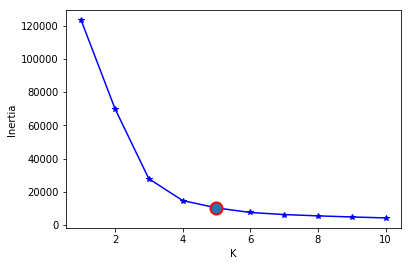

In [75]:
inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)
for k in ks:
    kmeans = KMeans(k).fit(X)
    inertias[k - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

elbow = np.argmin(diff3[3:]) + 3

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

In [76]:
X = np.loadtxt(os.path.join(temp_dir, "coords.csv"), delimiter="\t")
kmeans = KMeans(5).fit(X)
y = kmeans.labels_

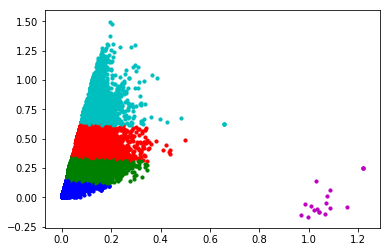

In [77]:
colors = ["b", "g", "r", "m", "c"]
#for i in range(X.shape[0]):
for i in range(100000):
    plt.scatter(X[i][0], X[i][1], c=colors[y[i]], s=10)    
plt.show()

### Bokeh

In [ ]:
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

In [ ]:
svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(tweet_counts)

df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:10000,0], documents_2d[:10000,1], range(len(bi_tweets[0:10000]))

source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

In [ ]:
full_df[full_df.index == 7743]

### Possibly try DBSCAN

In [3]:
with open('bi_tweets.pickle', 'rb') as f:
    bi_tweets = pd.read_pickle(f)

FileNotFoundError: [Errno 2] No such file or directory: 'bi_tweets.pickle'

In [7]:
string_tweets = []
for tweet in bi_tweets:
    string_tweets.append(' '.join(word.strip() for word in tweet))

In [8]:
string_tweets = pd.Series(string_tweets)

In [9]:
additional_stop_word_list = ['need', 'get', 'go', 'time', 'done', 'got', 'pre', 'lol', 'wanna', 'actually',
                             'im', 'just', 'like', 'want', 'gotta', 'dont', 'rt', 'retweet', 'amp', 'rr',
                             'mar', 'america', 'work', 'going', 'gonna', 'buddy', 'did', 'ready', 'true', 
                             'fall', 'year', 'thing', 'world', 'new', 'video', 'make', 'look', 'sure', 
                             'sense', 'new', 'happen', 'difference', 'let', 'come', 'say', 'tweet', 'medium', 
                             'think', 'way', 'know', 'friend', 'tell', 'try', 'wait', 'start', 'count', 'lot',
                             'hear', 'ill', 'home', 'house', 'bout', 'lil', 'yes', 'help', 'talk', 'guess',
                             #Descriptive
                             'feeling', 'good', 'great', 'best', 'really', 'nice', 'feel', 'thank', 'hate', 
                             'love', 'beautiful', 'bad', 'hard',
                             #Day Times
                             'today', 'morning', 'day', 'tomorrow', 'early', 'tonight', 'night', 'hour', 
                             'daily', 'late', 'week']
                             
                             #Gym Stop Words
                             #'workout', 'morning', 'feel', 'day', 'gym', 'tomorrow', 'partner', 'let', 
                             #'sleep', 'start', 'tonight', 'leg', 'eat', 'early', 'come', 'sore', 'hour', 
                             #'clothe', 'exercise', 'lost_weight', 'lose', 'play', 'sport', 'know', 'people' 
                             #'thing', 'think', 'right', 'thank', 'say', 'way', 'try', 'tell', 'lose_weight', 
                             #'help', 'fat', 'diet', 'food', 'motivation']

In [10]:
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_word_list)

In [11]:
num_topics = 3

In [12]:
vectorizer = CountVectorizer(analyzer='word', max_features=100000, stop_words=stop_words)
tweet_counts = vectorizer.fit_transform(string_tweets)

In [13]:
transformer = TfidfTransformer(smooth_idf=False);
tweet_tfidf = transformer.fit_transform(tweet_counts)

In [14]:
tweet_tfidf_norm = normalize(tweet_tfidf, norm='l1', axis=1)

In [15]:
nmf = NMF(n_components=num_topics, init='nndsvd')

In [16]:
nmf.fit(tweet_tfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=200, n_components=3, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [17]:
top_words = 20
feature_names = vectorizer.get_feature_names()
topic_dict = {}
for i in range(num_topics):
    word_idx = nmf.components_[i].argsort()[:-top_words-1:-1] 
    words = [feature_names[idx] for idx in word_idx]
    topic_dict['Topic # ' + '{:02d}'.format(i+1)] = words

**Topic 1 and 2 are garbage. These topics are covering the tweets that accounts put out to appear real**

In [18]:
topic_names = ['exercise', 'exercise', 'political/news']

In [19]:
pd.DataFrame(topic_dict)

,Topic # 01,Topic # 02,Topic # 03
0,workout,exercise,trump
1,gym,eat,president
2,partner,right,donald
3,kill,diet,news
4,sleep,walk,politic
5,leg,run,break
6,eat,people,obama
7,sore,ball,people
8,ass,lose_weight,vote
9,clothe,fat,hillary


In [20]:
t0 = time()
docweights = nmf.transform(tweet_tfidf)
print("done in %0.3fs." % (time() - t0))

done in 0.850s.


We can see the association between the topics by computing the inner product of the normal equations for the topic-document matrix.

A≈HW

**A is documents by words**

**H is documents by topics**

**W is topics by words.**

The product H′H is the association of the topics with each other based on occuring in the same documents.

The product WW′ is the association of the topics with each other based on their overlapping distributions of words.

In [21]:
A = tweet_tfidf
W = nmf.components_
H = nmf.transform(A)

print('A is {} x {}'.format(*A.shape))
print('W is {} x {}'.format(*W.shape))
print('H is {} x {}'.format(*H.shape))

A is 2116866 x 100000
W is 3 x 100000
H is 2116866 x 3


In [22]:
topic_df = pd.DataFrame({'topic':docweights.argmax(axis=1),
                         'tweet': string_tweets},
                  columns=['topic', 'tweet'])

In [23]:
topic_df[topic_df.topic==0].head()

,topic,tweet
3012,0,morning mariner musing manager scott_servai ex...
3400,0,mariner morning report the first day full squa...
3503,0,caitlyn_jenner partner with mac_lipstick enter...
6180,0,oso year later
8247,0,mayorsign


In [24]:
topic_df[topic_df.topic==1].head()

,topic,tweet
937,1,buzzfeed come seattle eat salmon and dumbfound...
1324,1,bishvat its seattle kind holiday for eat fruit...
2432,1,get ready for rainy week really rainy and wind...
3476,1,training exercise off africa become reallife n...
5791,1,you need give alcohol lose_weight not necessarily


In [25]:
true_topic_df = topic_df[topic_df.topic==2]

In [26]:
true_tweet_counts = vectorizer.fit_transform(true_topic_df.tweet)
true_tweet_tfidf = transformer.fit_transform(true_tweet_counts)

In [27]:
true_tweet_tfidf_norm = normalize(true_tweet_tfidf, norm='l1', axis=1)

In [28]:
num_topics = 5
nmf = NMF(n_components=num_topics, init='nndsvd')
nmf.fit(true_tweet_tfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=200, n_components=5, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [29]:
top_words = 20
feature_names = vectorizer.get_feature_names()
topic_dict = {}
for i in range(num_topics):
    word_idx = nmf.components_[i].argsort()[:-top_words-1:-1] 
    words = [feature_names[idx] for idx in word_idx]
    topic_dict['Topic # ' + '{:02d}'.format(i+1)] = words

In [30]:
topic_names = ['campaign/right', 'news/right', 'left/general', 'hashtag/left', 'news']

In [31]:
pd.DataFrame(topic_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,trump,news,people,blacklivesmatter,man
1,president,fake,white,black,police
2,donald,state,black,support,woman
3,politic,obama,right,blackskinisnotacrime,shoot
4,break,local,music,blacktwitter,kill
5,obama,kill,god,racism,black
6,vote,report,life,blm,arrest
7,hillary,attack,vote,life,charge
8,clinton,syria,obama,cop,break
9,supporter,win,american,movement,officer


In [32]:
t0 = time()
docweights = nmf.transform(true_tweet_tfidf)
print("done in %0.3fs." % (time() - t0))

done in 1.547s.


In [33]:
true_topic_df = pd.DataFrame({'topic':docweights.argmax(axis=1),
                              'tweet': true_topic_df.tweet},
                               columns=['topic', 'tweet'])

In [34]:
true_topic_df.head()


,topic,tweet
0,1,israeli police say palestinian home west bank ...
1,4,former iaaf chief lamine diack face new corrup...
2,4,spacex_launch rocket month after accident then...
3,1,the late fatality fear crash arkansa news
4,2,danish graceland museum change name after laws...


In [38]:
true_df = full_df.merge(true_topic_df, how='right', right_index=True, left_index=True)

In [39]:
analyser = sia()
sentiment = []
for sentence in true_df.content:
    ps = analyser.polarity_scores(sentence)
    sentiment.append(ps['compound'])
    

In [40]:
true_df['sentiment'] = sentiment

In [41]:
#with open('true_df.pickle', 'wb') as file:
#    pickle.dump(true_df, file, protocol=pickle.HIGHEST_PROTOCOL)

In [89]:
true_df.groupby(['author'])['tweet'].count().sort_values(ascending=False)

author
SCREAMYMONKEY      43914
WORLDNEWSPOLI      35009
AMELIEBALDWIN      33592
TODAYPITTSBURGH    33338
SPECIALAFFAIR      32380
SEATTLE_POST       30633
KANSASDAILYNEWS    28690
ROOMOFRUMOR        28222
DAILYSANFRAN       27884
WORLDOFHASHTAGS    22482
CHICAGODAILYNEW    22042
JENN_ABRAMS        20188
COVFEFENATIONUS    19960
EXQUOTE            19876
CHESPLAYSCHESS     18709
TODAYNYCITY        18425
ONLINECLEVELAND    17624
HYDDROX            16912
TODAYINSYRIA       15205
NEWORLEANSON       14786
DAILYSANDIEGO      14305
ARM_2_ALAN         14227
DAILYLOSANGELES    14060
TODAYMIAMI         13985
DETROITDAILYNEW    13893
CHRIXMORGAN        13819
PHOENIXDAILYNEW    13668
PHILADELPHIAON     13229
STLOUISONLINE      12645
CANNONSHER         12605
                   ...  
LARA_KICH              1
LAMARMUTANT            1
LADY_DIANAAAAA         1
MAGICATSALY            1
MAISURGANIM            1
DURTYTULIP             1
MEDVEDIHA777           1
MUHRASHMUH             1
BILAAL_RAIS       

In [52]:
true_df.to_csv('true_df.csv')

In [86]:
true_df[(true_df.account_type=='Right') & (true_df.author!='TEN_GOP')].sort_values(by=['followers'], ascending =False)[0:100]

,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018,tweet_id,topic,tweet,sentiment
1696145,JENN_ABRAMS,we are reaching levels of racism i never thoug...,United States,English,2017-07-22 12:20:00,22646,71022,25251,RETWEET,Right,1,RightTroll,0,888735612806856705,3,be reach level racism never think possible,-0.5106
1696146,JENN_ABRAMS,racism is everywhere fridayfeeling,United States,English,2017-07-22 12:21:00,22646,71022,25252,RETWEET,Right,1,RightTroll,0,888735665831149570,3,racism everywhere fridayfeeling,-0.6249
1696163,JENN_ABRAMS,abrams im a street raised city negro and ...,United States,English,2017-07-22 08:40:00,22645,71021,25250,RETWEET,Right,1,RightTroll,0,888680239991320578,4,abram street raise city negro and yeah cop tre...,0.7906
1696247,JENN_ABRAMS,patreon banned lauren southern cause activitie...,United States,English,2017-07-23 17:06:00,22631,71021,25283,NaN,Right,0,RightTroll,0,889169740131971072,4,patreon_ban lauren southern because activity s...,-0.6486
1696293,JENN_ABRAMS,i appreciate the transparency of jared kushner...,United States,English,2017-07-24 13:31:00,22651,71021,25287,RETWEET,Right,1,RightTroll,0,889478153483280384,4,appreciate the transparency jar_kushner refres...,0.4019
1696248,JENN_ABRAMS,everything is a race issue also these people t...,United States,English,2017-07-23 17:48:00,22631,71021,25284,NaN,Right,0,RightTroll,0,889180309232664576,2,everything race issue also these people think ...,-0.8360
1696148,JENN_ABRAMS,macron and his teacher who is also his future ...,United States,English,2017-07-22 12:45:00,22646,71020,25254,NaN,Right,0,RightTroll,0,888741841402826752,4,macron and his teacher who also his future wife,0.0000
1696294,JENN_ABRAMS,stop using children to push a political narrat...,United States,English,2017-07-24 14:06:00,22651,71020,25288,NaN,Right,0,RightTroll,0,889487058678546432,4,stop use child push political narrative course...,-0.7003
1696151,JENN_ABRAMS,ban the use of eyes because sight excludes bli...,United States,English,2017-07-22 14:09:00,22646,71019,25260,NaN,Right,0,RightTroll,0,888762809902878720,2,ban the use eye because sight exclude blind pe...,-0.7430
1696246,JENN_ABRAMS,someone asked if traps were gay at a gaming ev...,United States,English,2017-07-23 16:32:00,22631,71019,25282,NaN,Right,0,RightTroll,0,889161184653570049,4,someone ask trap be gay gaming event the organ...,0.0000


In [138]:
true_df[(true_df.author=='JENN_ABRAMS')& (true_df.publish_date>'2016-03-21')&(true_df.publish_date<'2016-03-23')].loc[1688465]


author                                             JENN_ABRAMS
content             liar liar white house potentially on fire 
region                                           United States
language                                               English
publish_date                               2016-03-21 17:36:00
following                                                18596
followers                                                50406
updates                                                  14681
post_type                                                  NaN
account_type                                             Right
retweet                                                      0
account_category                                    RightTroll
new_june_2018                                                0
tweet_id                                    711969652558016513
topic                                                        2
tweet                   liar liar white house potential

In [ ]:
true_df[true_df.author=='CRYSTAL1JOHNSON']

In [150]:
true_df[true_df.account_category=='NewsFeed'].groupby(['author'])['followers'].mean().sort_values(ascending=False)


author
TODAYNYCITY        61274.697585
WASHINGTONLINE     30811.814640
NEWORLEANSON       26996.072298
KANSASDAILYNEWS    24740.520181
TODAYINSYRIA       22386.459849
SANANTOTOPNEWS     19694.506976
CHICAGODAILYNEW    19417.641049
DALLASTOPNEWS      19067.126251
ONLINEMEMPHIS      18766.391207
DETROITDAILYNEW    18074.379688
DAILYLOSANGELES    17985.134851
WARFAREWW          17293.425107
ATLANTA_ONLINE     16734.916152
DAILYSANFRAN       16684.285002
HOUSTONTOPNEWS     16661.029120
TODAYCINCINNATI    16640.320114
PHILADELPHIAON     15817.697029
ONLINECLEVELAND    15770.584260
TODAYMIAMI         15544.069932
DAILYSANDIEGO      15260.136945
ELPASOTOPNEWS      14662.752846
TODAYBOSTONMA      14417.844614
PHOENIXDAILYNEW    14363.869988
DAILYSANJOSE       12974.747739
SEATTLE_POST       12597.643326
SCREAMYMONKEY      12487.825796
TODAYPITTSBURGH    12458.085908
ROOMOFRUMOR        12273.815180
MINNEAPOLISON      12238.803398
POLIT_OBSERVER     11963.923913
OAKLANDONLINE      11096.926434
S

In [141]:
true_df[true_df.author=='CRYSTAL1JOHNSON'].loc[1887571].content


'the first allmale public high school in ohio founded by ted ginn im so proud '